In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

# Make plots pretty
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid',
              palette='deep', font='sans-serif',
              font_scale=1, color_codes=True, rc=None)

Using matplotlib backend: TkAgg


# Lab 8
### Ian Eykamp

The average power efficiency of our converter is 78%, which is very stable across input voltages and time. The efficiency decreases by less than 1% for input voltages between 18V and 13V. For an output power of 20W, the input power is around 25.5W, which means about 5.5W of power is lost. I get to gloat here that this matches my guesstimation from the pre-lab quite well.

   Vg (V)  Ig (A)  Vout (V)   Pg (W)  Iout (A)  Pout (W)  Efficiency (%)
0   18.05   1.454     10.16  26.2447     2.032  20.64512       78.663959
1   17.00   1.495     10.00  25.4150     2.000  20.00000       78.693685
2   16.00   1.590     10.00  25.4400     2.000  20.00000       78.616352
3   15.00   1.707     10.00  25.6050     2.000  20.00000       78.109744
4   14.00   1.834     10.00  25.6760     2.000  20.00000       77.893753
5   13.00   1.760      9.43  22.8800     1.886  17.78498       77.731556


(76.0, 81.0)

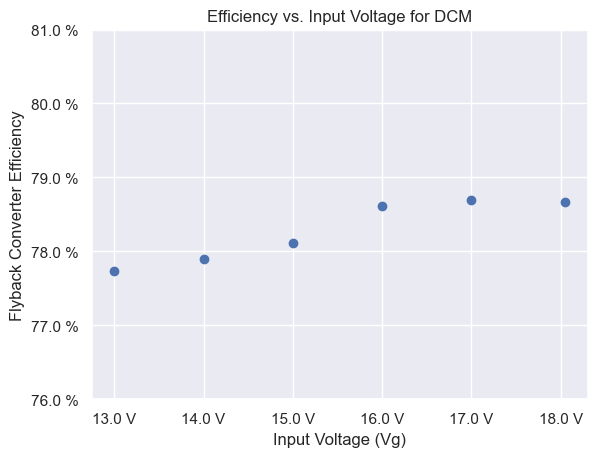

In [28]:
Rload = 5 # Ohms
power_measurements = pd.read_csv("input_current_voltage.csv")
power_measurements["Pg (W)"] = power_measurements["Vg (V)"] * power_measurements["Ig (A)"]
power_measurements["Iout (A)"] = power_measurements["Vout (V)"] / Rload
power_measurements["Pout (W)"] = power_measurements["Vout (V)"] * power_measurements["Iout (A)"]
power_measurements["Efficiency (%)"] = power_measurements["Pout (W)"] / power_measurements["Pg (W)"] * 100
# power_measurements.drop(index = 5, inplace = True) # get rid of bogus last value which gave 120% efficiency
print(power_measurements)

plt.figure()
helper.axes_labels("Input Voltage (Vg)", "V", "Flyback Converter Efficiency", "%", title = "Efficiency vs. Input Voltage for DCM")
plt.scatter(power_measurements["Vg (V)"], power_measurements["Efficiency (%)"])
plt.ylim([76, 81])

The efficiency decreases monotonically with lower input voltage, but over the whole range of DCM operation, the efficiency only varies by less than 1%. Therefore, I conclude that the losses almost entirely depend on factors that are not input voltage-dependent.

## Oscilloscope Data

Maximum voltages for Vg = 18.05: max(Vsh) = 0.3696V, max(Vd) = 46.84V
Maximum voltages for Vg = 17.0: max(Vsh) = 0.3672V, max(Vd) = 45.32V
Maximum voltages for Vg = 16.0: max(Vsh) = 0.3672V, max(Vd) = 44.24V
Maximum voltages for Vg = 15.0: max(Vsh) = 0.368V, max(Vd) = 43.44V
Maximum voltages for Vg = 14.0: max(Vsh) = 0.3664V, max(Vd) = 42.4V
Maximum voltages for Vg = 13.0: max(Vsh) = 0.348V, max(Vd) = 40.16V


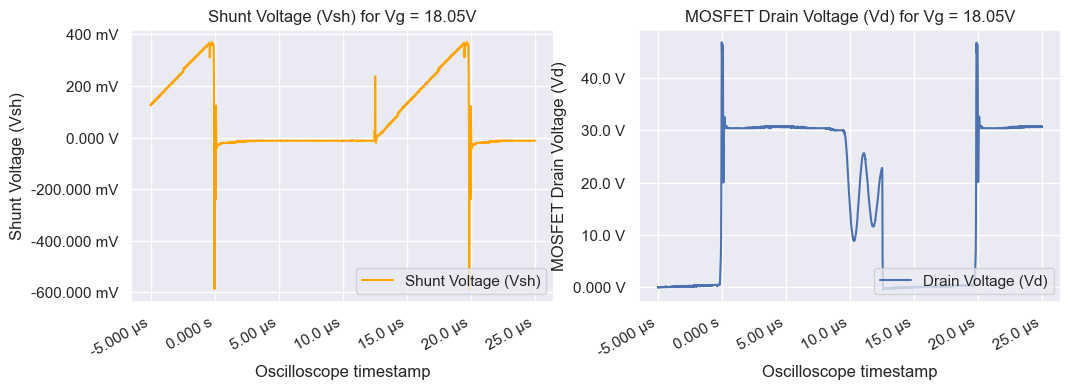

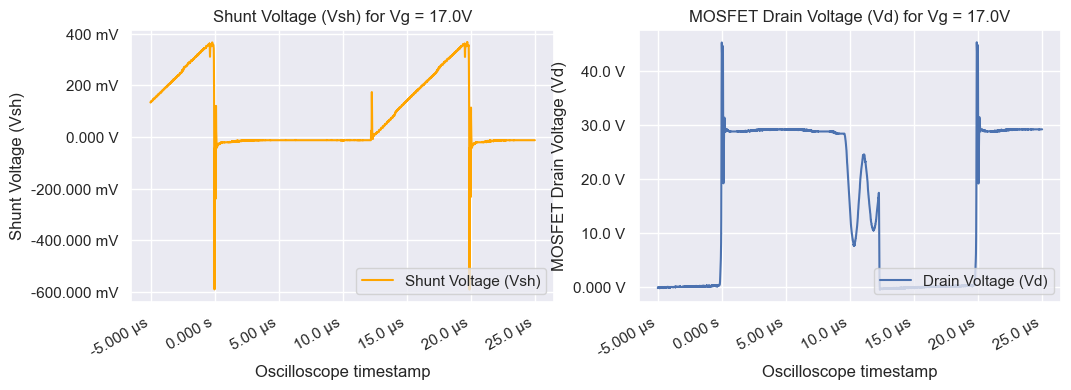

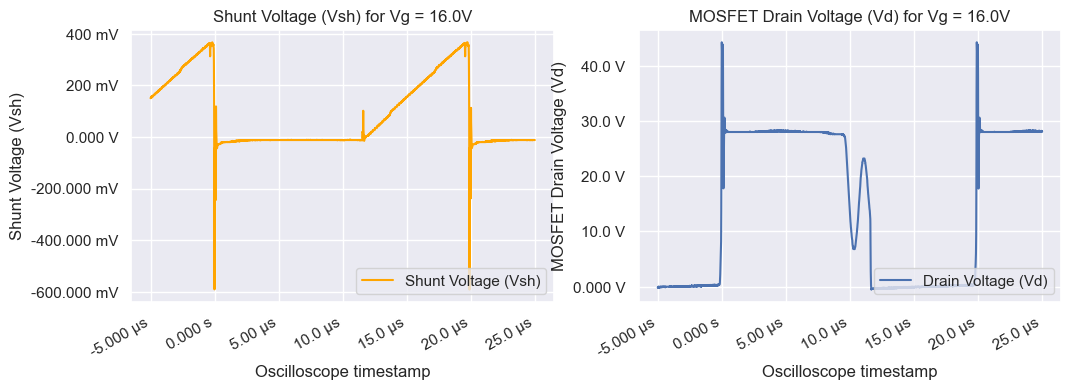

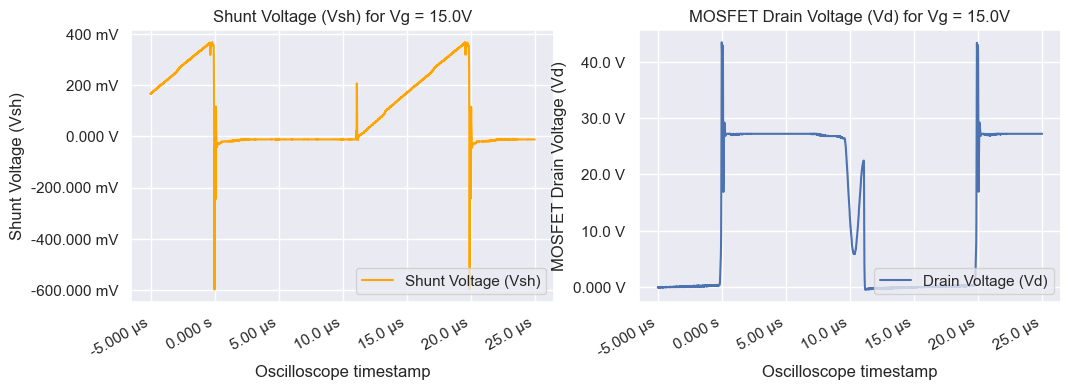

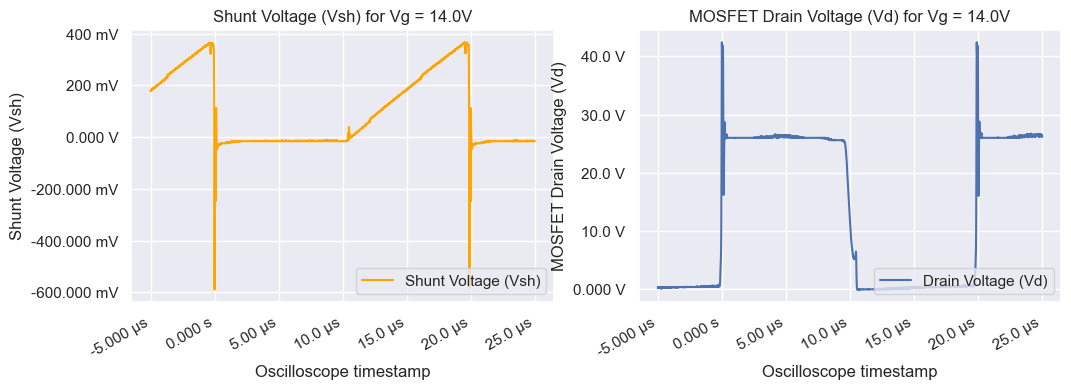

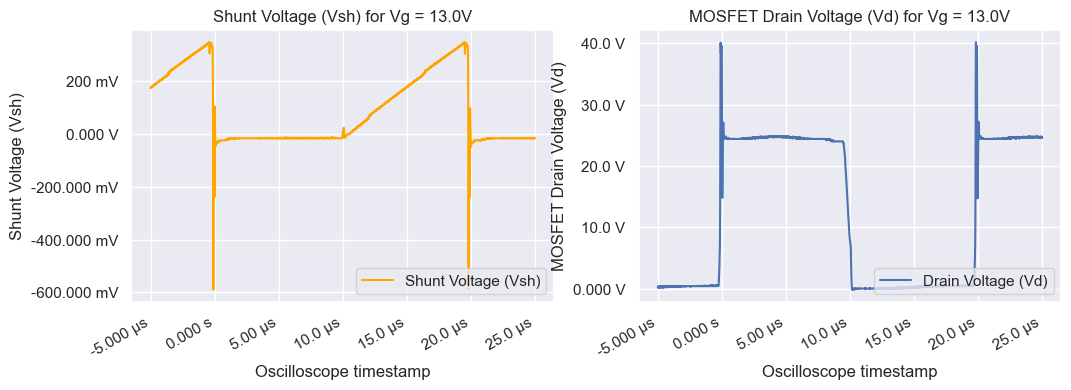

In [29]:
filenames = ["Newfile59", "Newfile60", "Newfile1", "Newfile2", "Newfile3", "Newfile4"]

max_vsh = []
max_vd = []

for index, row in power_measurements.iterrows():
    (df_oscilloscope, tspan, tstep) = helper.read_rigol_csv(f"oscilloscope_data/{filenames[index]}.csv", ch1 = "Vsh", ch2 = "Vd")
    df_zoom = df_oscilloscope[(df_oscilloscope["t"] > -5e-6) & (df_oscilloscope["t"] < 25e-6)]

    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = False, figsize = (12, 4))
    fig.autofmt_xdate()
    helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = f"Shunt Voltage (Vsh) for Vg = {row['Vg (V)']}V", ax = ax1)
    ax1.plot(df_zoom["t"], df_zoom["Vsh"], color = "orange", label = "Shunt Voltage (Vsh)")
    ax1.legend(loc = "lower right")

    helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Drain Voltage (Vd)", "V", title = f"MOSFET Drain Voltage (Vd) for Vg = {row['Vg (V)']}V", ax = ax2)
    ax2.plot(df_zoom["t"], df_zoom["Vd"], label = "Drain Voltage (Vd)")
    ax2.legend(loc = "lower right")

    max_vsh.append(max(df_zoom['Vsh']))
    max_vd.append(max(df_zoom['Vd']))
    print(f"Maximum voltages for Vg = {row['Vg (V)']}: max(Vsh) = {np.round(max(df_zoom['Vsh']), 4)}V, max(Vd) = {np.round(max(df_zoom['Vd']), 2)}V")


Above are the shunt and drain voltage waveforms. The most relevant feature is the duration of the low-frequency ringing after the diode shutoff. At decreasing input voltages, you can see the discontinuous part of the duty cycle becoming shorter and shorter until continuous conduction is reached at Vg = 13V.

## Peak Shunt and Drain Voltage

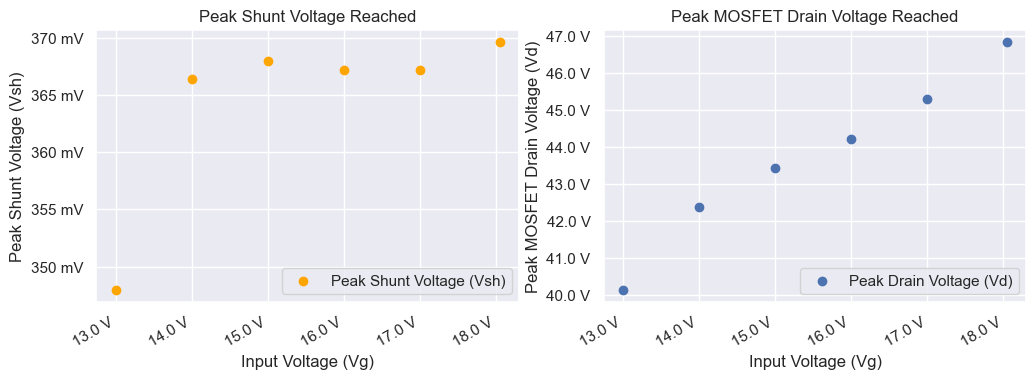

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = False, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Input Voltage (Vg)", "V", "Peak Shunt Voltage (Vsh)", "V", title = "Peak Shunt Voltage Reached", ax = ax1)
ax1.scatter(power_measurements["Vg (V)"], max_vsh, color = "orange", label = "Peak Shunt Voltage (Vsh)")
ax1.legend(loc = "lower right")

helper.axes_labels("Input Voltage (Vg)", "V", "Peak MOSFET Drain Voltage (Vd)", "V", title = "Peak MOSFET Drain Voltage Reached", ax = ax2)
ax2.scatter(power_measurements["Vg (V)"], max_vd, label = "Peak Drain Voltage (Vd)")
ax2.legend(loc = "lower right")

Somewhere between Vg = 13V and 14V, the converter switched from Discontinuous Conduction Mode (DCM) to Continuous Conduction Mode (CCM). During CCM, the peak current can be smaller because current is flowing constantly through the inductor, including an elevated baseline inductor current. The elevated baseline inductor current means that the ripple can be smaller both for the output current and the input current. Therefore, it makes sense to see such a big drop in the peak shunt voltage between Vg = 13V and 14V.

The peak MOSFET drain voltage is linearly related to the input voltage with a slope of 1. This makes sense, because the peak voltage is limited by the RCD clamp, and the clamp is referenced to the input voltage.

## Switching Losses

Power Losses
--------
Full Cycle Power Loss: 2.06 W
--------
MOSFET Shut-off Power Loss: 1.24 W
Diode Shut-off Power Loss: 2.92 mW
MOSFET Turn-on Power Loss: 103.59 mW


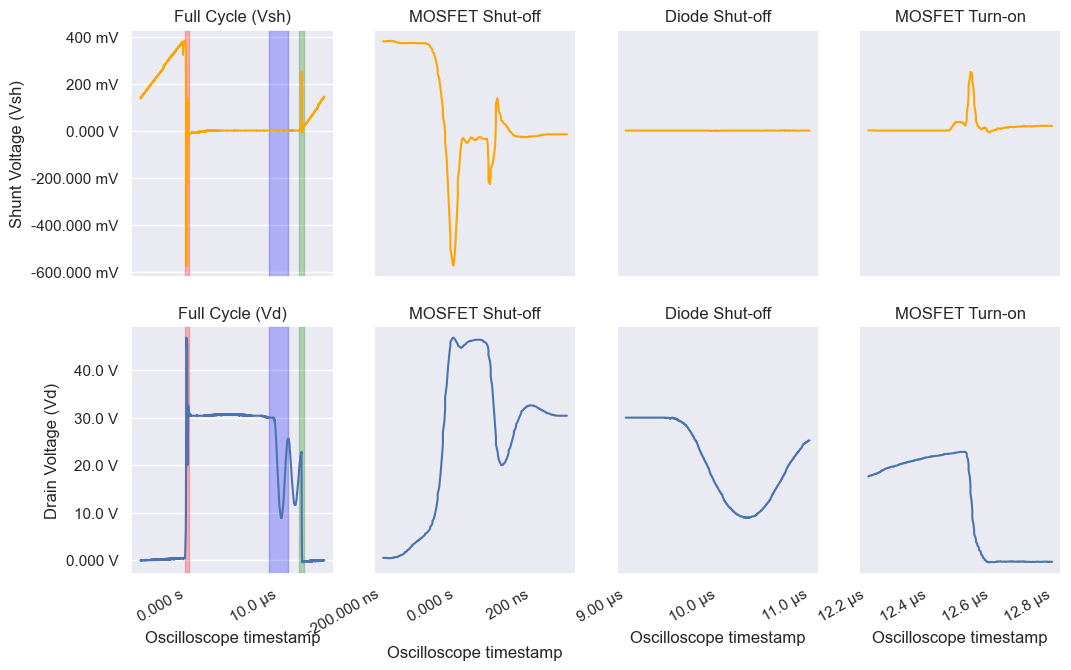

In [31]:
def plot_regions(cycle_ts, cycle_ts_name, switch_off_ts, switch_off_ts_name, diode_off_ts, diode_off_ts_name, switch_on_ts, switch_on_ts_name):

    (df_18V, tspan, tstep) = helper.read_rigol_csv(f"oscilloscope_data/{filenames[0]}.csv", ch1 = "Vsh", ch2 = "Vd")
    df_18V["Vsh"] = df_18V["Vsh"] + 12e-3 # V measuring offset

    df_zoom           = df_18V[(df_18V["t"] > cycle_ts[0]) & (df_18V["t"] < cycle_ts[1])]
    df_zoom_switch_off = df_18V[(df_18V["t"] > switch_off_ts[0]) & (df_18V["t"] < switch_off_ts[1])]
    df_zoom_diode_off = df_18V[(df_18V["t"] > diode_off_ts[0]) & (df_18V["t"] < diode_off_ts[1])]
    df_zoom_switch_on = df_18V[(df_18V["t"] > switch_on_ts[0]) & (df_18V["t"] < switch_on_ts[1])]

    my_alpha = 0.25
    fig, ((ax11, ax12, ax13, ax14), (ax21, ax22, ax23, ax24)) = plt.subplots(nrows = 2, ncols = 4, sharex = False, sharey = False, figsize = (12, 8))
    fig.autofmt_xdate()
    helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = cycle_ts_name + " (Vsh)", ax = ax11)
    ax11.plot(df_zoom["t"], df_zoom["Vsh"], color = "orange")
    ax11.axvspan(switch_off_ts[0], switch_off_ts[1], color = 'red', alpha = my_alpha)
    ax11.axvspan(diode_off_ts[0], diode_off_ts[1], color = 'blue', alpha = my_alpha)
    ax11.axvspan(switch_on_ts[0], switch_on_ts[1], color = 'green', alpha = my_alpha)

    helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = switch_off_ts_name, ax = ax12)
    ax12.plot(df_zoom_switch_off["t"], df_zoom_switch_off["Vsh"], color = "orange")
    # ax12.axvline(x = 0e-6, linestyle = "dashed", color = "black")

    helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = diode_off_ts_name, ax = ax13)
    ax13.plot(df_zoom_diode_off["t"], df_zoom_diode_off["Vsh"], color = "orange")

    helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = switch_on_ts_name, ax = ax14)
    ax14.plot(df_zoom_switch_on["t"], df_zoom_switch_on["Vsh"], color = "orange")

    # fig, (ax21, ax22, ax23, ax24) = plt.subplots(nrows = 1, ncols = 4, sharex = False, sharey = True, figsize = (12, 4))
    # fig.autofmt_xdate()
    helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = cycle_ts_name + " (Vd)", ax = ax21)
    ax21.plot(df_zoom["t"], df_zoom["Vd"])
    ax21.axvspan(switch_off_ts[0], switch_off_ts[1], color = 'red', alpha = my_alpha)
    ax21.axvspan(diode_off_ts[0], diode_off_ts[1], color = 'blue', alpha = my_alpha)
    ax21.axvspan(switch_on_ts[0], switch_on_ts[1], color = 'green', alpha = my_alpha)

    helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = switch_off_ts_name, ax = ax22)
    ax22.plot(df_zoom_switch_off["t"], df_zoom_switch_off["Vd"])
    # ax22.axvline(x = 0e-6, linestyle = "dashed", color = "black")

    helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = diode_off_ts_name, ax = ax23)
    ax23.plot(df_zoom_diode_off["t"], df_zoom_diode_off["Vd"])

    helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = switch_on_ts_name, ax = ax24)
    ax24.plot(df_zoom_switch_on["t"], df_zoom_switch_on["Vd"])

    # ax11.get_shared_y_axes().join(ax11, ax12, ax14)
    ax11.get_shared_y_axes().join(ax11, ax12, ax13, ax14)
    ax21.get_shared_y_axes().join(ax21, ax22, ax23, ax24)
    ax12.get_yaxis().set_visible(False)
    ax13.get_yaxis().set_visible(False)
    ax14.get_yaxis().set_visible(False)
    ax11.get_xaxis().set_visible(False)
    ax12.get_xaxis().set_visible(False)
    ax13.get_xaxis().set_visible(False)
    ax14.get_xaxis().set_visible(False)
    ax22.get_yaxis().set_visible(False)
    ax23.get_yaxis().set_visible(False)
    ax24.get_yaxis().set_visible(False)

    ax12.xaxis.grid(False)
    ax13.xaxis.grid(False)
    ax14.xaxis.grid(False)
    ax11.xaxis.grid(False)
    ax12.xaxis.grid(False)
    ax13.xaxis.grid(False)
    ax14.xaxis.grid(False)
    ax21.xaxis.grid(False)
    ax22.xaxis.grid(False)
    ax23.xaxis.grid(False)
    ax24.xaxis.grid(False)

    ax12.yaxis.grid(True)
    ax13.yaxis.grid(True)
    ax14.yaxis.grid(True)
    ax11.yaxis.grid(True)
    ax12.yaxis.grid(True)
    ax13.yaxis.grid(True)
    ax14.yaxis.grid(True)
    ax21.yaxis.grid(True)
    ax22.yaxis.grid(True)
    ax23.yaxis.grid(True)
    ax24.yaxis.grid(True)

    def to_abs_or_not_to_abs(x):
        return np.abs(x)

    print("Power Losses")
    print("--------")
    # df_lf_trapz = df_zoom[np.logical_not(np.isnan(df_zoom["Vsh_hf_snub_lf"]))]
    cycle_switch_area = np.trapz(to_abs_or_not_to_abs(df_zoom["Vsh"]) * to_abs_or_not_to_abs(df_zoom["Vd"]), df_zoom["t"])
    print(f"{cycle_ts_name} Power Loss:", (cycle_switch_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))
    print("--------")
    switch_off_area = np.trapz(to_abs_or_not_to_abs(df_zoom_switch_off["Vsh"]) * to_abs_or_not_to_abs(df_zoom_switch_off["Vd"]), df_zoom_switch_off["t"])
    print(f"{switch_off_ts_name} Power Loss:", (switch_off_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))
    diode_off_area = np.trapz(to_abs_or_not_to_abs(df_zoom_diode_off["Vsh"]) * to_abs_or_not_to_abs(df_zoom_diode_off["Vd"]), df_zoom_diode_off["t"])
    print(f"{diode_off_ts_name} Power Loss:", (diode_off_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))
    switch_on_area = np.trapz(to_abs_or_not_to_abs(df_zoom_switch_on["Vsh"]) * to_abs_or_not_to_abs(df_zoom_switch_on["Vd"]), df_zoom_switch_on["t"])
    print(f"{switch_on_ts_name} Power Loss:", (switch_on_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))



cycle_ts = (-5e-6, 15e-6)
switch_off_ts = (-0.2e-6, 0.3e-6)
diode_off_ts = (9e-6, 11e-6)
switch_on_ts = (12.2e-6, 12.8e-6)

plot_regions(
        cycle_ts = cycle_ts, cycle_ts_name = "Full Cycle",
        switch_off_ts = switch_off_ts, switch_off_ts_name = "MOSFET Shut-off", 
        diode_off_ts = diode_off_ts, diode_off_ts_name = "Diode Shut-off", 
        switch_on_ts = switch_on_ts, switch_on_ts_name = "MOSFET Turn-on"
)

In the above plots, I isolated various regions of the switching cycle. The MOSFET current is the shunt voltage divided by the shunt resistor, $\frac{V_{sh}}{R_{shunt}} = I$. For each region, the integral of the power $P = I(t) \cdot V_d(t)$ is taken and reported above the figure (multiplied by the switching frequency). The regions were chosen to isolate the switching losses from the cycle.

I had to add a constant offset of 12mV to the `Vsh` voltage. Otherwise, the shunt voltage was not centered at 0V even when the MOSFET was off, leading to large errors in my power integration results. I attribute the 12mV difference to measurement error, and I assume the actual leakage current to be negligible (on the order of pA).

The MOSFET turn-off switching loss is around 700mW, which dominates the MOSFET power loss of ~1W total (estimating based on positive and negative power dissipation values). The MOSFET turn-on switching loss is only around 100mW, which is much smaller. This is expected because we are in Discontinuous Conduction Mode (DCM), which means the current is negligible at the time we turn the switch on.

Power Losses
--------
Full Cycle Power Loss: 2.07 W
--------
Diode Is On Power Loss: 44.90 mW
Diode Is Off Power Loss: 25.26 mW
MOSFET Is On Power Loss: 113.38 mW


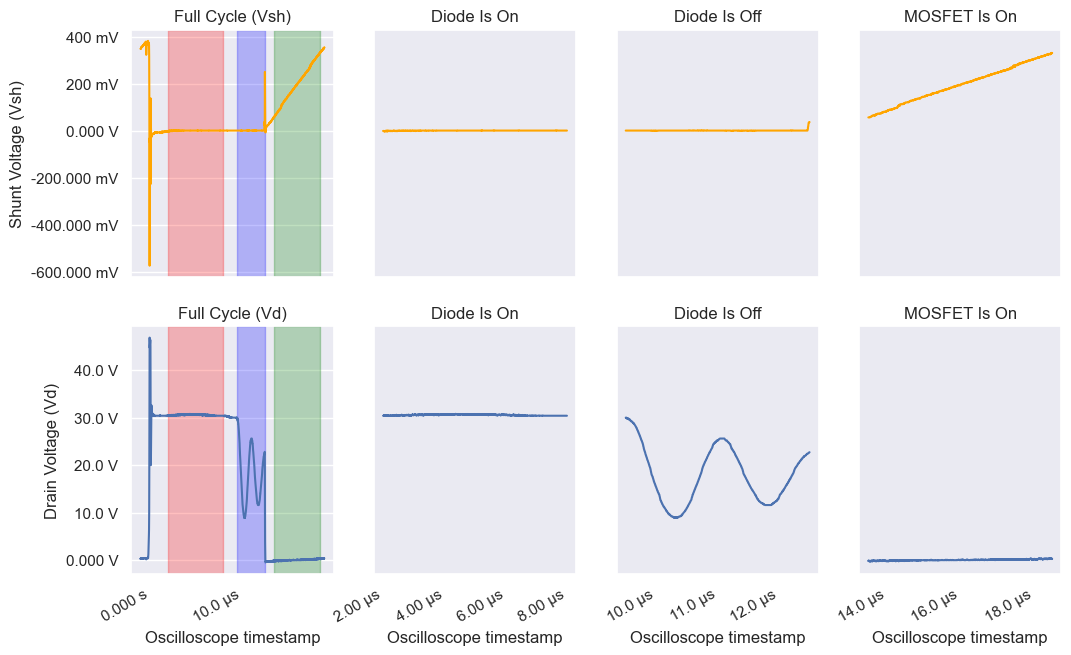

In [32]:
cycle_ts = (-1e-6, 19e-6)
diode_is_on_ts = (2e-6, 8e-6)
diode_is_off_ts = (9.5e-6, 12.5e-6)
switch_is_on_ts = (13.5e-6, 18.5e-6)

plot_regions(
        cycle_ts = cycle_ts, cycle_ts_name = "Full Cycle", 
        switch_off_ts = diode_is_on_ts, switch_off_ts_name = "Diode Is On", 
        diode_off_ts = diode_is_off_ts, diode_off_ts_name = "Diode Is Off", 
        switch_on_ts = switch_is_on_ts, switch_on_ts_name = "MOSFET Is On"
)

Similarly, the non-switching regions have minimal power dissipation despite making up a much larger fraction of the switching cycle.

In addition, the shunt resistor dissipates power whenever current flows through it by $P_{sh} = V_{sh}^2 / I$. Taking the integral of $P_{sh}(t)$ over an entire switching cycle and multiplying by the switching frequency yields around 400mV.

Shunt Resistor Power Loss: 402.97 mW


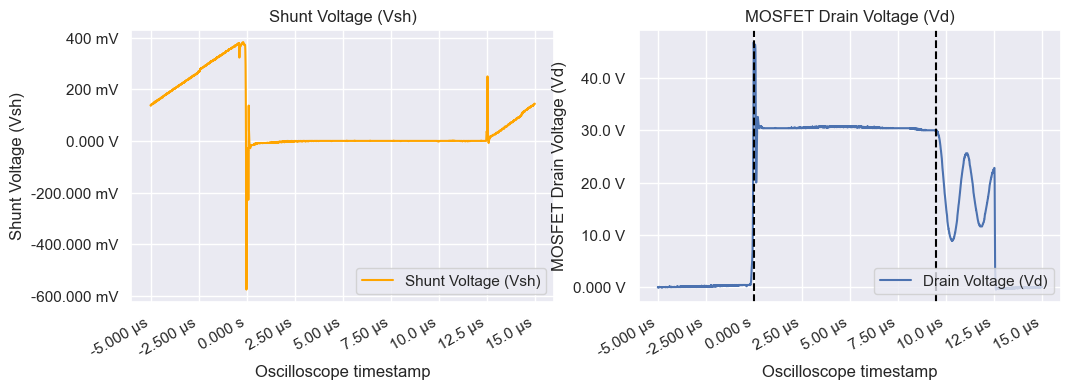

In [33]:
cycle_ts = (-5e-6, 15e-6)

(df_18V, tspan, tstep) = helper.read_rigol_csv(f"oscilloscope_data/{filenames[0]}.csv", ch1 = "Vsh", ch2 = "Vd")
df_18V["Vsh"] = df_18V["Vsh"] + 12e-3 # V measuring offset
df_zoom = df_18V[(df_18V["t"] > cycle_ts[0]) & (df_18V["t"] < cycle_ts[1])]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = False, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh)", ax = ax1)
ax1.plot(df_zoom["t"], df_zoom["Vsh"], color = "orange", label = "Shunt Voltage (Vsh)")
ax1.legend(loc = "lower right")

helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Drain Voltage (Vd)", "V", title = "MOSFET Drain Voltage (Vd)", ax = ax2)
ax2.plot(df_zoom["t"], df_zoom["Vd"], label = "Drain Voltage (Vd)")
ax2.legend(loc = "lower right")

Rload = 0.05 # Ohm
cycle_switch_area = np.trapz(df_zoom["Vsh"] ** 2 / Rload, df_zoom["t"])
print(f"Shunt Resistor Power Loss:", (cycle_switch_area * units.volt ** 2 * units.second / units.ohm * 50 * units.kilohertz).to_compact(units.watt))

diode_on_duration = 9.5e-6 # s
ax2.axvline(x = 0, linestyle = "dashed", color = "black")
ax2.axvline(x = diode_on_duration, linestyle = "dashed", color = "black")

In [34]:
delta_V = 15 * units.volt
Rsnubber = 10 * units.ohm
R_AC = 4.47 * units.ohm
P_per_cycle = delta_V ** 2 / (Rsnubber + R_AC)
W_per_cycle = P_per_cycle * 200 * units.nanosecond
P_overall =  W_per_cycle * 50 * units.kilohertz
print("Snubber + AC Resistance Power Dissipation:", P_overall.to_compact(units.watt))

V_F = 0.68 * units.volt
I_D = 2 * units.amp
P_D_per_cycle = V_F * I_D
P_D = P_D_per_cycle * diode_on_duration * units.second * 50 * units.kilohertz
print("Diode Power Dissipation:", P_D.to_compact(units.watt))

Snubber + AC Resistance Power Dissipation: 155.49 mW
Diode Power Dissipation: 646.00 mW


## Putting It All Together

We have to account for 5.5W of power dissipation. We have close to 1W of switching loss from the MOSFET turn-off and 400mV from the shunt resistor. For Lab 7, the clamp design calculations involved estimating the energy stored in the leakage inductance that would need to be dissipated each cycle. This yielded close to 1W, after scaling by the clamp voltage ratio (since more energy is dissipated by the clamp than is stored in the leakage inductance). I do not know if this quantity includes energy dissipated by the snubber, clamp, and AC resistance together.

During the high-frequency ringing, the snubber brings the ringing down from the clamp voltage to the steady-state drain voltage in a matter of 200ns. The voltage drop is 15V, the snubber resistor is $10 \Omega$ in series with an AC resistance of $4.47 \Omega$ for high frequency calculated in Lab 7, and the power dissipation is $P = \Delta V^2/(R_{snubber} + R_{AC}) \approx 155mW$. This is a small enough quantity that it may be either neglected or treated as part of the leakage inductance power dissipation accounted for under the clamp.

From prior work, I estimated the magnetic losses due to hysteresis to be around 90mW.

The output current is 2A on average. The forward voltage across the diode is 0.68V. Therefore, the diode dissipates $P = I_D V_F$ when it carries forward current. The diode only carries current between the time when the MOSFET turns off and when the inductor runs out of current. For our operating conditions, this works out to about 9.5us per switching cycle (vertical bars in the graph above). Overall, the diode dissipates around 600mW.

### FLIR Images
![FLIR Image 100 (thermal spectrum camera)](flir_images/FLIR0100.jpg)
![FLIR Image 101 (visible spectrum camera)](flir_images/FLIR0101.jpg)

From the FLIR images, the hotspots are on the components already identified, such as the MOSFET, diode, and transformer. The leakage inductance should not be producing heat in the transformer itself; the energy should mostly be dissipated in the snubber and clamp components. Perhaps I underestimated the winding resistance and AC resistance which occurs in the transformer itself. The transformer has a large thermal mass, so it must be dissipating a large amount of heat for its temperature to rise so much. By comparison, the diode gets very hot because it is one component dissipating around 600mW of power, without the aid of a heat sink. However, the diode always remains within its temperature operating conditions (150degrees C) according to the datasheet.

### Power Dissipation Pie Chart

                     Loss (mW)
Switching Loss         1020.00
Leakage Inductance      984.03
Diode When On           646.00
Shunt Resistor          402.97
Snubber + AC            155.49
Magnetic Hysteresis      90.00

Total Calculated Losses: 3298.49 mW
Total Observed Losses: 5.49 W
Losses Unaccounted For: 2.19 W


<AxesSubplot:title={'center':'Power Loss Breakdown, Total = 5.49W'}>

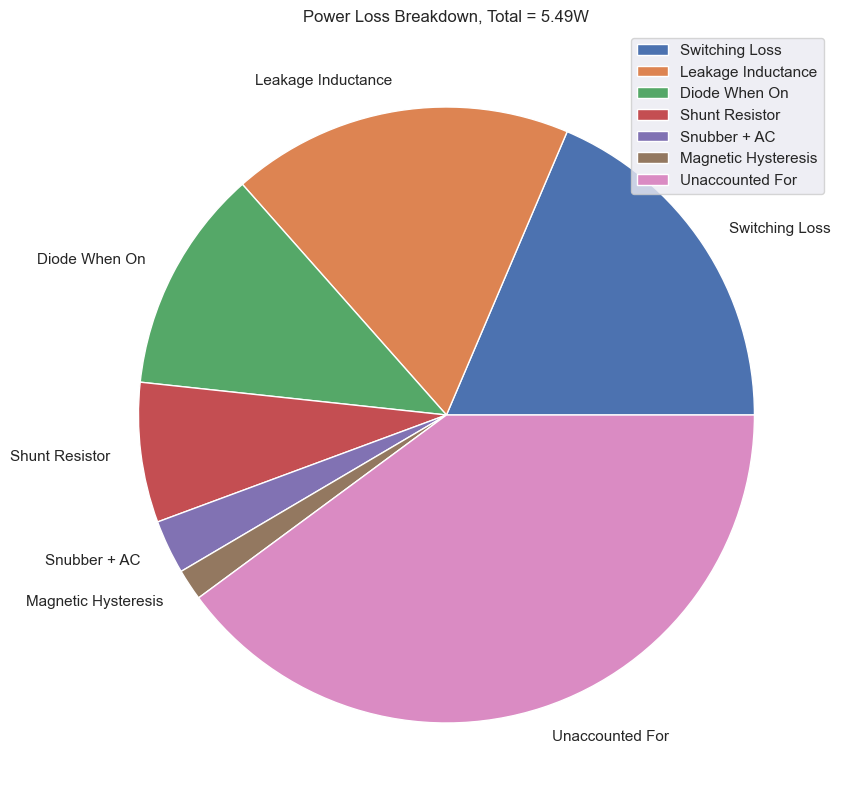

: 

In [35]:
power_losses = pd.DataFrame({
    "Switching Loss": 1020, 
    "Leakage Inductance": 984.03, 
    "Diode When On": 646, 
    "Shunt Resistor": 402.97, 
    "Snubber + AC": 155.49, 
    "Magnetic Hysteresis": 90, 
}, index = ["Loss (mW)"]).transpose()

total_calculated_losses = power_losses.sum(axis = 0)[0] * units.milliwatt
total_observed_losses = np.mean(power_measurements["Pg (W)"][1:4] - power_measurements["Pout (W)"][1:4]) * units.watt
unaccounted_losses = total_observed_losses - total_calculated_losses
print(power_losses)
print("================")
print()
print("Total Calculated Losses:", total_calculated_losses)
print("Total Observed Losses:", total_observed_losses)
print("Losses Unaccounted For:", unaccounted_losses)

power_losses_total = power_losses.transpose()
power_losses_total["Unaccounted For"] = unaccounted_losses.to(units.milliwatt).magnitude
power_losses_total = power_losses_total.transpose()
# print(power_losses_total)
power_losses_total.plot.pie(y = 0, figsize = (10, 10), title = "Power Loss Breakdown, Total = 5.49W", ylabel = "")